<a href="https://www.kaggle.com/code/kenny3s/resnet50?scriptVersionId=173066919" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from fastai.vision.all import *
from fastai.optimizer import Adam
import torchvision
path=Path("/kaggle/input/oxford-pets/images")
files=get_image_files(path)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

dir_path = "/kaggle/input/oxford-pets/images"
dir_names = [name for name in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, name))]
label_to_num = {label: num for num, label in enumerate(dir_names)}
num_to_label = {k:v for k, v in enumerate(dir_names)}

In [4]:
classes = len(label_to_num)
classes

35

In [5]:
# 定义label_func函数
def label_func(filepath):
    return filepath.parent.name

class TripletImage(fastuple):
    def show(self, loss=None, pred=None, p=None, ctx=None, **kwargs): 
        if len(self) > 3:
                img1,img2,img3,similarity = self
        else:
            img1,img2,img3 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            if img3.size != img1.size: img3 = img3.resize(img1.size)
            t1,t2,t3 = tensor(img1),tensor(img2), tensor(img3)
            t1,t2,t3 = t1.permute(2,0,1),t2.permute(2,0,1),t3.permute(2,0,1)
        else: t1,t2,t3 = img1,img2,img3
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        if loss == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=similarity, ctx=ctx, **kwargs)
        elif pred == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{loss:.2f}", ctx=ctx, **kwargs)
        return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{pred}/{similarity} {loss:.2f} / {p:.2f}", ctx=ctx, **kwargs)

class TripletTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(get_image_files(path/l)) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2, f3, anchor = self.valid.get(f, self._draw(f,0))
        img1,img2,img3 = PILImage.create(f),PILImage.create(f2),PILImage.create(f3)
        return TripletImage(img1, img2, img3, int(label_to_num[anchor]))
    
    def _draw(self, f, split=0):
        cls1 = label_func(f)
        cls2 = random.choice(L(l for l in labels if l != cls1))
        while len(self.lbl2files[cls2]) == 0: 
            cls2 = random.choice(L(l for l in labels if l != cls1))
        return random.choice(self.lbl2files[cls1]),random.choice(self.lbl2files[cls2]),cls1
    
@typedispatch
def show_batch(x:TripletImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=3, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): TripletImage(x[0][i], x[1][i], x[2][i], num_to_label[x[3][i].item()]).show(ctx=ctx)
    
splits = RandomSplitter(seed=42)(files)
labels = list(set(files.map(label_func)))
tfm = TripletTransform(files, parent_label, splits)
tls = TfmdLists(files, tfm, splits=splits)

dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

#*aug_transforms()
class TripletModel(Module):
    def __init__(self, encoder):
        self.encoder= encoder
    def forward(self, x1, x2, x3):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x3 = self.encoder(x3)
        return x1, x2, x3

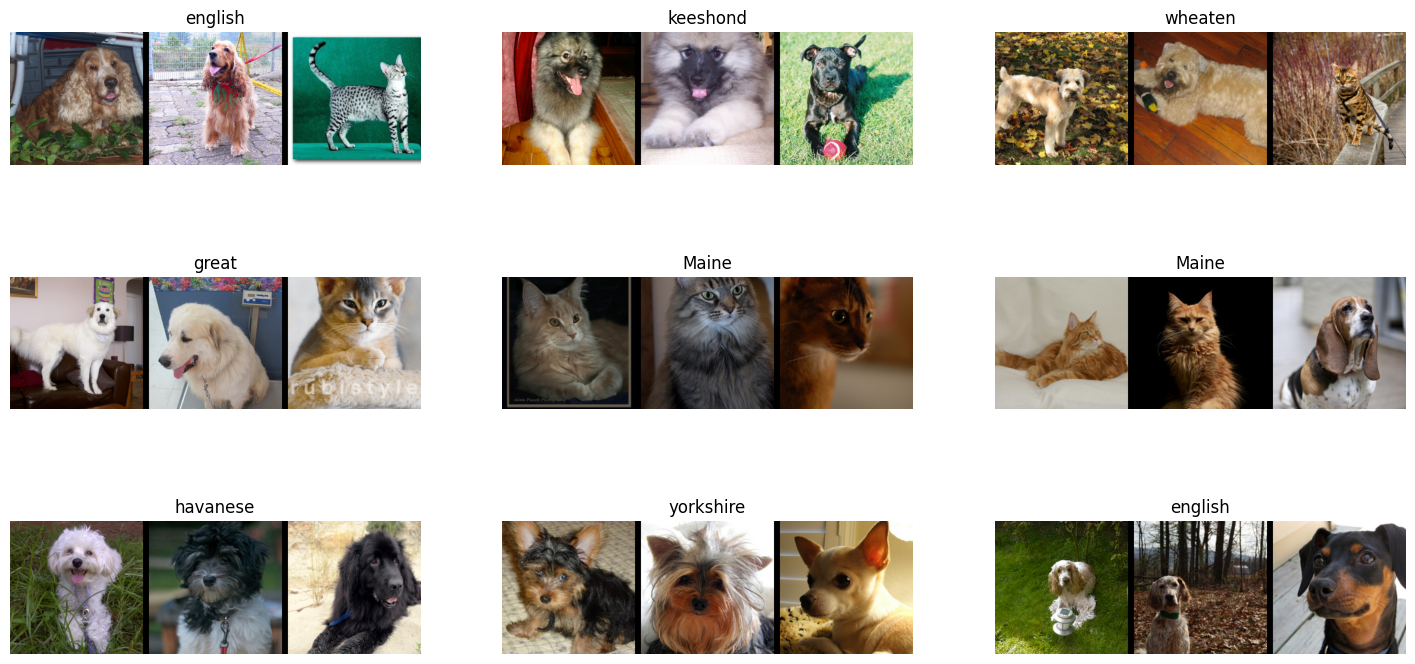

In [6]:
dls.show_batch()

In [7]:
MNv3L=mobilenet_v3_large(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 66.6MB/s]


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(MNv3L, cut=-1)
model = TripletModel(encoder)

In [9]:
class _Loss(Module):
    reduction: str
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction


class triplet_loss_func(_Loss):
    __constants__ = ['margin', 'p', 'eps', 'swap', 'reduction']
    margin: float
    p: float
    eps: float
    swap: bool

    def __init__(self, margin: float = 1.0, p: float = 2., eps: float = 1e-6, swap: bool = False, size_average=None,
                 reduce=None, reduction: str = 'mean'):
        super(triplet_loss_func, self).__init__(size_average, reduce, reduction)
        self.margin = margin
        self.p = p
        self.eps = eps
        self.swap = swap
    def forward(self, x, *args):
        anchor, positive, negative = x[0], x[1], x[2]
        
        return F.triplet_margin_loss(anchor, positive, negative, margin=self.margin, p=self.p,
                                     eps=self.eps, swap=self.swap, reduction=self.reduction)

In [10]:
learn = Learner(
    dls, 
    model, 
    loss_func=triplet_loss_func(), 
    opt_func=Adam,
    cbs=[ShowGraphCallback, SaveModelCallback]
)

In [11]:
#learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.817703,75.472496,01:10
1,0.942698,0.969485,01:05
2,0.946741,0.967180,01:04
3,0.890938,0.862363,01:04
4,0.869835,0.836204,01:04


Better model found at epoch 0 with valid_loss value: 75.47249603271484.


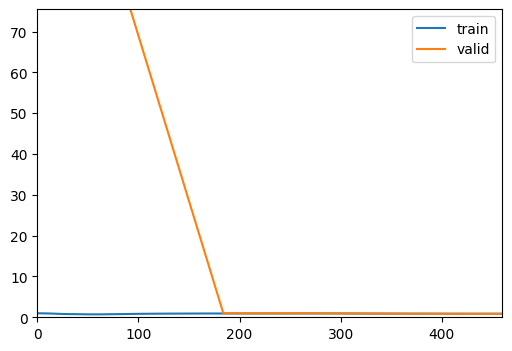

Better model found at epoch 1 with valid_loss value: 0.9694849252700806.
Better model found at epoch 2 with valid_loss value: 0.9671797752380371.
Better model found at epoch 3 with valid_loss value: 0.8623634576797485.
Better model found at epoch 4 with valid_loss value: 0.8362038731575012.


In [12]:
learn.freeze()
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.855330,0.833485,01:05
1,0.854487,0.832025,01:03
2,0.846206,0.816357,01:03
3,0.819052,0.782666,01:03
4,0.814342,0.773721,01:04
5,0.797659,0.763444,01:06
6,0.803037,0.768972,01:03
7,0.800238,0.758585,01:02
8,0.788596,0.752793,01:02
9,0.787728,0.751440,01:02


Better model found at epoch 0 with valid_loss value: 0.8334847688674927.


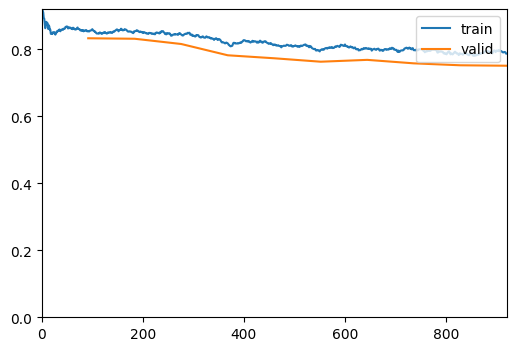

Better model found at epoch 1 with valid_loss value: 0.8320252895355225.
Better model found at epoch 2 with valid_loss value: 0.8163568377494812.
Better model found at epoch 3 with valid_loss value: 0.7826659083366394.
Better model found at epoch 4 with valid_loss value: 0.7737210392951965.
Better model found at epoch 5 with valid_loss value: 0.7634437680244446.
Better model found at epoch 7 with valid_loss value: 0.7585846781730652.
Better model found at epoch 8 with valid_loss value: 0.7527927160263062.
Better model found at epoch 9 with valid_loss value: 0.7514402866363525.


In [13]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5,1e-3))

In [14]:
def triplet_top_losses(learn, preds=None, max_n=10, n_cols=2):
    if preds == None:
        preds = learn.get_preds(with_loss=True, with_input=True)
    ctxs = get_grid(max_n, nrows=None, ncols=n_cols, figsize=(n_cols*6, max_n//n_cols * 3), title='Triplet Loss')
    dl = learn.dls.valid.enumerate()
    topk = preds[-1].topk(max_n)
    start = time.time()
    for i, ctx in enumerate(ctxs):
        idx = topk[-1][i].item()
        loss = topk[0][i].item()
        dl[idx][1].show(loss=loss, ctx=ctx)

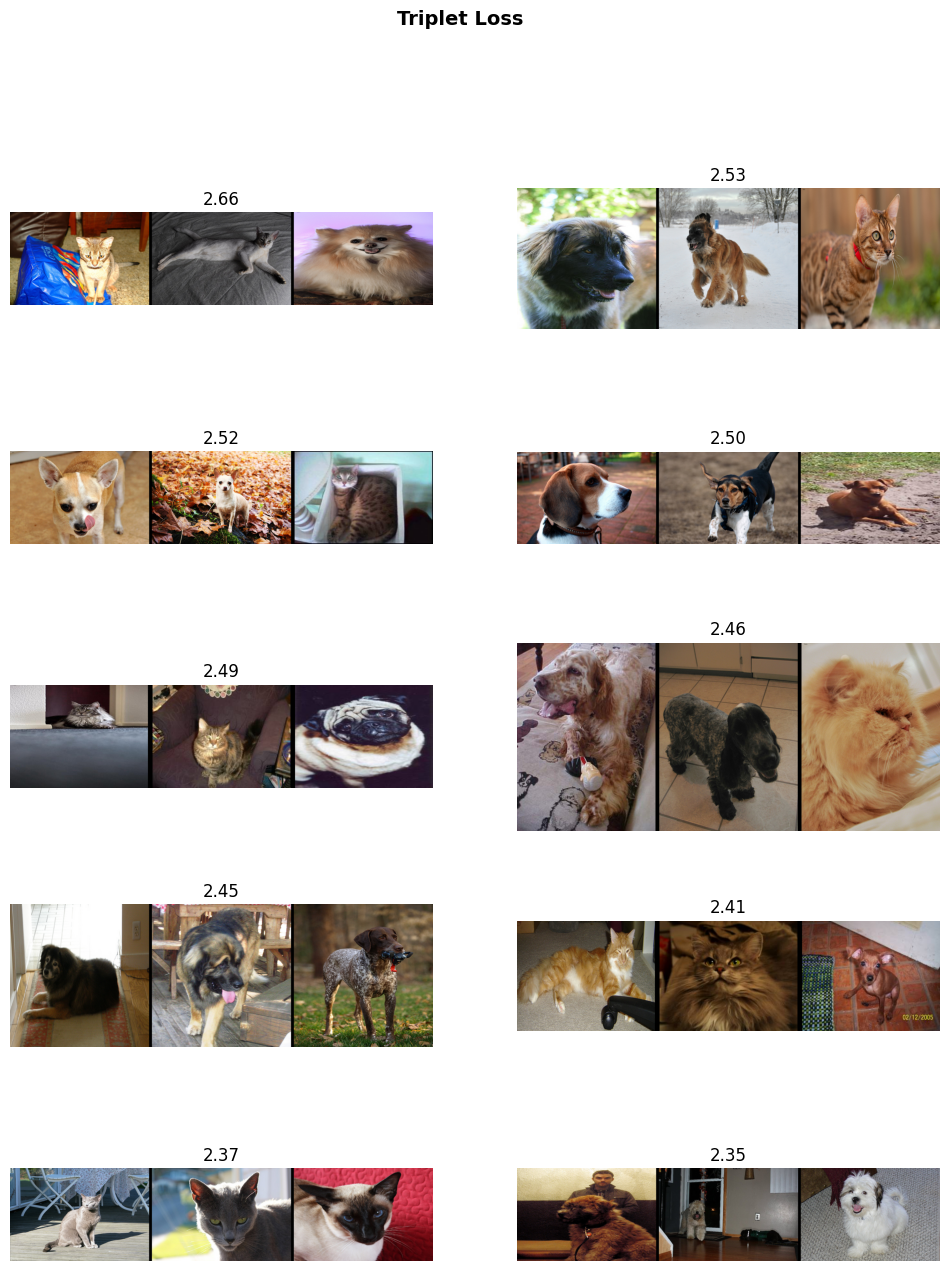

In [15]:
triplet_top_losses(learn)

In [16]:
hooks = Hooks(model.encoder, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0], i[1], i[2])
    ftrs = torch.cat((ftrs, nn.Flatten()(hooks.stored[-1])))

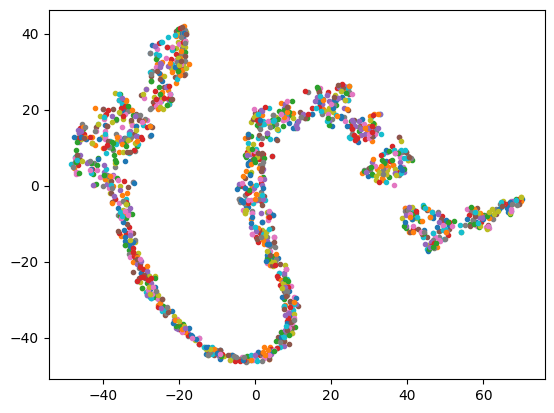

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

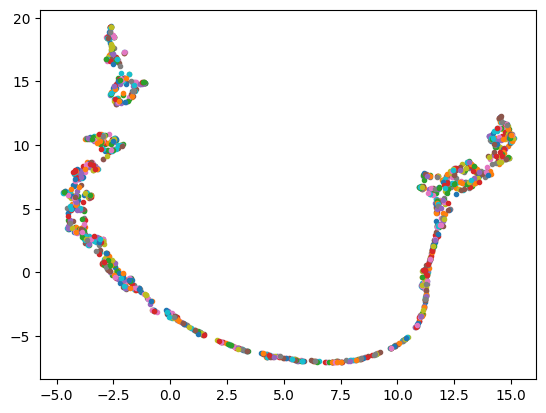

In [18]:
from umap import UMAP
umap = UMAP(n_components=2)
output = umap.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

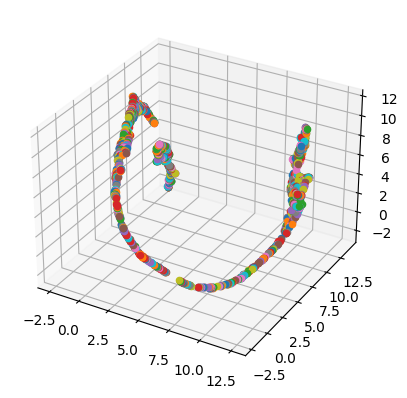

In [19]:
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
umap = UMAP(n_components=3)
output = umap.fit_transform(ftrs.cpu().detach().numpy())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(output)):
    ax.scatter(output[i, 0], output[i, 1], output[i, 2])
plt.show()